In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
% cd "/content/drive/My Drive/nnfl_project/"

/content/drive/My Drive/nnfl_project


# Imports


In [3]:
%tensorflow_version 1.x

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from keras.utils import to_categorical
import os
import glob
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.layers import *
#Input,Activation, Dense, Embedding, Flatten, LSTM, Conv1D,MaxPooling1D,Dropout,Bidirectional,Reshape,MaxPooling1D,GlobalMaxPooling1D, Dropout,Permute,TimeDistributed,BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.regularizers import l1_l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import load_model
from keras import regularizers
from keras.utils.vis_utils import plot_model

from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import datapath, get_tmpfile

PATH = '/content/drive/My Drive/nnfl_project/'
DATA_PATH = '/content/drive/My Drive/nnfl_project/data'
GLOVE_PATH = '/content/drive/My Drive/glove.840B.300d.txt'

TensorFlow 1.x selected.


Using TensorFlow backend.


# Helper Functions

In [0]:
def evaluate(model,y_texts, y_labels, batch_size):
  loss, acc = model.evaluate(y_texts,y_labels,batch_size=batch_size,verbose=1)
  # print("Accuracy of the model",acc)
  y_pred = model.predict(y_texts, batch_size=batch_size)
  y_pred_max_ind = np.argmax(y_pred,axis=1)
  y_true_max_ind = np.argmax(y_labels,axis=1)
  cf = (classification_report(y_true_max_ind,y_pred_max_ind))
  confusion_mat = confusion_matrix(y_true_max_ind, y_pred_max_ind)

  print("\n Model Accuracy : ",acc)
  print("\n Confusion Matrix: \n", confusion_mat)
  print("\nClassification Report\n ",cf)

# model_op_folder = 'new_conv1d_GMP_split'
def get_callbacks():

  chk_pth = ("{epoch:02d}_{val_categorical_accuracy:.2f}.h5")
  # early stopping
  earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=4)
  checkpoint = ModelCheckpoint(chk_pth,monitor='val_categorical_accuracy', verbose=1, save_weights_only=True, save_best_only='True',mode = 'auto', period=2)

  # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose = 1)
  cb = [checkpoint,earlyStop]
  return cb

def run_model(model, train_tokenized_seq, train_labels, epochs, batch_size, vsplit, init_epoch=0):

  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01),metrics=['categorical_accuracy'])

  # check if a saved_model exists
  # if(glob.glob('*.h5')):
  #   print("loading model")
  #   load_path = return_last_saved_model(glob.glob('*.h5'))
  #   # model = load_model(load_path)
  #   model.load_weights(load_path)
  #   init_epoch = get_epoch_frm_model_file(load_path)

  print("START TRAINING")

  start = time.time()
  # history = model.fit(train_tokenized_seq,train_labels,epochs = init_epoch+epochs, batch_size=batch_size, validation_data=(test_tokenized_seq, test_labels), callbacks=[checkpoint,earlyStop], initial_epoch=init_epoch)
  history = model.fit(train_tokenized_seq,train_labels,epochs = init_epoch+epochs, batch_size=batch_size, validation_split=vsplit, callbacks=get_callbacks(), initial_epoch=init_epoch)
  end =  time.time()
  print("Training fininshed")
  # save_path = "{}_epochs-model.h5".format(init_epoch+epochs)
  # model.save(save_path)
  print("Average Time per epoch: ", (end-start)/len(history.history['loss']))
  return history

# plot model

def training_plots(history, model_name, model):  
  plt.plot(history.history["categorical_accuracy"])
  plt.plot(history.history["val_categorical_accuracy"])
  plt.title('model acc')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plot_model(model,to_file=model_name,show_shapes=True)

def tokenize_sequences(texts, sl, tokenizer):
  sequences = tokenizer.texts_to_sequences(texts)
  sequences = pad_sequences(sequences, maxlen=sl)

  return sequences

def get_data(data_path):
  newsgroups_data_train = fetch_20newsgroups(data_path,subset='train')
  train_labels = newsgroups_data_train.target
  train_texts = newsgroups_data_train.data

  newsgroups_data_test = fetch_20newsgroups(data_path,subset='test')
  test_labels = newsgroups_data_test.target
  test_texts = newsgroups_data_test.data
  return train_texts,train_labels, test_texts, test_labels

def get_epoch_frm_model_file(save_path):
  return int(save_path[:save_path.index('_')])
  # return int(save_path.split('_')[2])

def return_last_saved_model(paths):
  last_epoch_prev = -1
  ret_path = ""
  for path in paths:
    last_epoch = get_epoch_frm_model_file(path)
    if(last_epoch >= last_epoch_prev):
      last_epoch_prev = last_epoch
      ret_path = path
  return ret_path

def get_embedding_matrix(word2ix, glove_path, embedding_dim):
    """
    :param path: path to the glove embeddings file
    :param tokenizer: tokenizer fitted on the documents
    :param vocab_size: vocabulary size 
    :return: an embedding matrix: a nn.Embeddings
    """
    glove_vectors = {}
    glove_file = open(glove_path, 'r')
    for line in tqdm(glove_file):
        split_line = line.rstrip().split()
        word = split_line[0]
        if len(split_line) != (embedding_dim + 1) or word not in word2ix:
            continue
        assert (len(split_line) == embedding_dim + 1)
        vector = np.array([float(x) for x in split_line[1:]], dtype="float32")
        assert len(vector) == embedding_dim
        glove_vectors[word] = vector

    glove_file.close()

    print("Number of pre-trained word vectors loaded: ", len(glove_vectors))

    # Calculate mean and stdev of embeddings
    all_embeddings = np.array(list(glove_vectors.values()))
    embeddings_mean = float(np.mean(all_embeddings))
    embeddings_stdev = float(np.std(all_embeddings))

    vocab_size = len(word2ix)
    # Randomly initialize an embedding matrix of (vocab_size, embedding_dim) shape
    # with a similar distribution as the pretrained embeddings for words in vocab.
    embedding_matrix = np.random.normal(embeddings_mean, embeddings_stdev, (vocab_size, embedding_dim))

    for i, word in enumerate(word2ix):
        if word in glove_vectors:
            embedding_matrix[i] = glove_vectors[word]

    return embedding_matrix

# load embedding as a dict
# the following functions are for word2vec embeddings
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab,embed_dim_w):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, embed_dim_w))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in embedding:
            weight_matrix[i] = embedding.get(word)
    return weight_matrix

def get_w2v_matrix(vocab, embed_dim_w):
  # load embedding from file
  raw_embedding = load_embedding('word2vec_200.txt')
  # get vectors in the right order
  return(get_weight_matrix(raw_embedding, vocab,embed_dim_w))

def prepare_for_word_to_vec(texts):
  words_list = []
  for text in texts:
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    words_list.append(words)
  return words_list


# Configs

In [0]:
# in paper
vocab_size = 40439
embed_dim = 300 
embed_dim_w = 200
hidden_dim  = 128
batch_size  = 128
epochs = 10
init_epoch = 0
sl = 300
vsplit = 0.05

# Process Data

In [0]:
# save_embedding_matrix_path = PATH + 'embedding_matrix.pkl'
train_texts,train_labels, test_texts, test_labels = get_data(DATA_PATH)

# Should fit_to_texts complete or only train-  https://stackoverflow.com/questions/54891464/is-it-better-to-keras-fit-to-text-on-the-entire-x-data-or-just-the-train-data

tokenizer = Tokenizer(oov_token='<UNK>', num_words=vocab_size+1)
# fit only on train
tokenizer.fit_on_texts(train_texts)

# word2ix = truncated vocabulary or original vocabulary
word2ix = list(tokenizer.word_index.keys())[:vocab_size+1]
word2ix = {k:tokenizer.word_index[k] for k in word2ix}

train_tokenized_seq = tokenize_sequences(train_texts, sl, tokenizer)
test_tokenized_seq = tokenize_sequences(test_texts, sl, tokenizer)
# vocab_size = len(tokenizer.word_index)# +1 for OOV

train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))
output_dim = train_labels.shape[1]


# W2V model

In [0]:
# word2vec mpdel
path = get_tmpfile(PATH+'word2vec_200.txt')
if(glob.glob('word2vec_200.txt')):
  print("loading word2vec model")
  model_w = KeyedVectors.load_word2vec_format(path)
else:
  import nltk
  nltk.download('punkt')
  from nltk.tokenize import word_tokenize
  w_train = prepare_for_word_to_vec(train_texts)
  w_test = prepare_for_word_to_vec(test_texts)
  model_w = Word2Vec(w_train+w_test,size=embed_dim_w,sg=1,iter = 15)


# load weights
if(glob.glob('w2v_weights_200.pkl')):
  print("loading w2v weights")
  w2v_weights = np.load('w2v_weights_200.pkl', allow_pickle=True)
  # vocab_size_w=vocab_size+1

else:
  # get weights
  w2v_weights = get_w2v_matrix(tokenizer.word_index,embed_dim_w)
  # save weights
  pth = PATH+'w2v_weights_200.pkl'
  with open(pth, 'wb+') as f:
      pickle.dump(w2v_weights, f)

vocab_size_w=vocab_size+1


w2v_weights.shape
print(vocab_size_w)


# Glove

In [7]:
save_embedding_matrix_path = PATH + 'embedding_matrix_truncated.pkl'

if(glob.glob(save_embedding_matrix_path)):
  print('Embedding matrix found. Loading ...')
  with open(save_embedding_matrix_path, 'rb') as f:
    embedding_matrix = pickle.load(f)

  print('Done.')

else:
  embedding_matrix = get_embedding_matrix(word2ix, GLOVE_PATH, embed_dim)
  with open(save_embedding_matrix_path, 'wb+') as f:
    pickle.dump(embedding_matrix, f)


Embedding matrix found. Loading ...
Done.


In [0]:
save_embedding_matrix_path = PATH + 'embedding_matrix_w2vec.pkl'

if(glob.glob(save_embedding_matrix_path)):
  print('Embedding matrix found. Loading ...')
  with open(save_embedding_matrix_path, 'rb') as f:
    embedding_matrix = pickle.load(f)

  print('Done.')

else:
  embedding_matrix = get_w2v_matrix(tokenizer.word_index, embed_dim_w)
  with open(save_embedding_matrix_path, 'wb+') as f:
    pickle.dump(embedding_matrix, f)


Embedding matrix found. Loading ...
Done.


In [8]:
print(train_tokenized_seq.shape)
print(train_labels.shape)

print(embedding_matrix.shape)
print(vocab_size)

(11314, 300)
(11314, 20)
(40440, 300)
40439


# Models

## WRNN (with LSTM unit)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if sys.path[0] == '':


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          12132000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          219648    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 128)          16512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0   

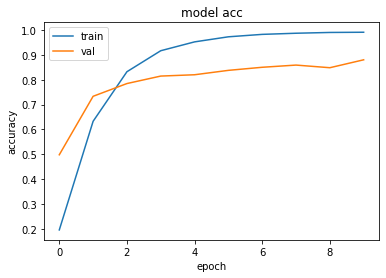

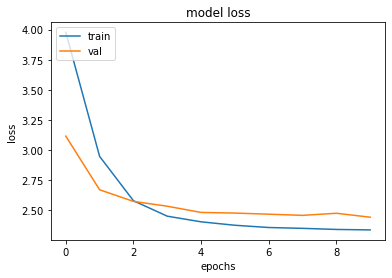

Evaluating...
7532/7532 [==============================] - 6s 793us/step

 Model Accuracy :  0.7606213688850403

 Confusion Matrix: 
 [[186   0   0   2   0   0   0   9   2   0   1   2   9   1   6  40  11   1
    4  45]
 [  0 267  15  26  14  16  13   3   0   0   1   4  14   9   6   1   0   0
    0   0]
 [  0  15 263  44  13   5   5   7   0   0   0   0  33   0   4   0   4   1
    0   0]
 [  0   8  25 285  20   3  23   1   0   0   0   1  26   0   0   0   0   0
    0   0]
 [  0   6   4  40 291   1  14   3   0   0   0   0  24   0   1   0   1   0
    0   0]
 [  0  31  28  10   5 305   4   3   1   0   0   1   6   0   0   0   0   1
    0   0]
 [  0   4   3  16   7   1 340   2   1   0   1   1  11   1   2   0   0   0
    0   0]
 [  2   1   1   2   4   1  27 291  12   1   4   1  41   2   4   0   0   0
    1   1]
 [  1   2   0   1   0   1  14  12 349   0   1   0   8   2   6   0   1   0
    0   0]
 [  0   5   1   0   0   0  10   4   2 333  21   0   6   6   5   1   0   0
    2   1]
 [  0   0   0   

In [9]:
# architecture 
inp = Input(shape=(sl,))
embed = Embedding(input_dim=vocab_size+1, output_dim=embed_dim, weights=[embedding_matrix], input_length=sl, trainable=True)(inp)
lstm = LSTM(hidden_dim, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(embed) # o/p 300x128
# Note o/p of a rnn cel or lstm cell gives prob of each word - (300,)
# conv 1d inp shape - (128,300) -- reshape needed
# r2 = Reshape((hidden_dim, sl))(lstm)
conv1d = Conv1D(128,1, activation='relu')(lstm)
gp = GlobalMaxPooling1D()(conv1d)
d = Dense(hidden_dim, activation='relu')(gp)
d = Dropout(0.1)(d)
out = Dense(output_dim, activation='softmax', activity_regularizer=l1_l2(0.01,0.01))(d)
model_wrnn = Model(input = inp, outputs = out)
model_wrnn.summary()

# training
history = run_model(model_wrnn, train_tokenized_seq, train_labels, epochs, batch_size, vsplit)
training_plots(history, 'wrnn.png', model_wrnn)

# evaluation
print("Evaluating...")
evaluate(model_wrnn, test_tokenized_seq, test_labels, batch_size)

## WRNN (with GRU unit)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if sys.path[0] == '':


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 300, 300)          12132000  
_________________________________________________________________
gru_3 (GRU)                  (None, 300, 128)          164736    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 300, 128)          16512     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0   

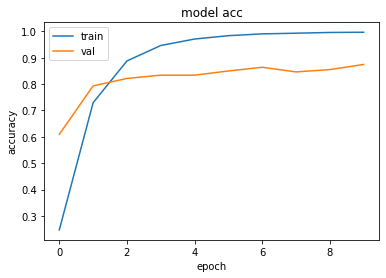

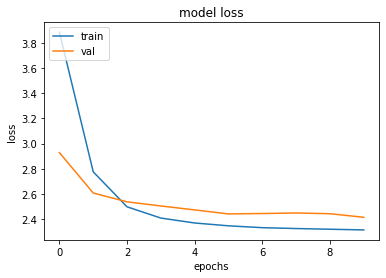

Evaluating...
7532/7532 [==============================] - 12s 2ms/step

 Model Accuracy :  0.7867764234542847

 Confusion Matrix: 
 [[212   0   2   1   0   2   2   4   2   5   3   2   4   5   5  34   1   0
    4  31]
 [  2 260  16  23   9  30   8   8   3   1   0   4  13   9   2   0   0   0
    1   0]
 [  0  17 273  40  13   8   1   2   8   2   0   3   5   5   8   2   3   0
    2   2]
 [  0  12  16 308  14   2  18   2   1   1   0   0  16   1   0   0   1   0
    0   0]
 [  0   6   6  33 303   0   7   7   0   0   0   0  21   0   1   0   0   1
    0   0]
 [  0  33  23   1   4 322   7   0   0   0   0   0   1   3   0   0   1   0
    0   0]
 [  0   2   4  16   9   1 326   6   3   0   2   0  17   2   2   0   0   0
    0   0]
 [  0   4   5   5   2   0  11 334   8   0   0   0  23   1   0   1   0   0
    2   0]
 [  0   1   2   2   4   0   9  15 358   1   0   2   3   1   0   0   0   0
    0   0]
 [  0   0   1   1   0   1   9   3   1 342  22   1   4   6   1   0   0   0
    2   3]
 [  0   0   0   0

In [0]:
# architecture 
inp = Input(shape=(sl,))
embed = Embedding(input_dim=vocab_size+1, output_dim=embed_dim, weights= [embedding_matrix], input_length=sl, trainable = True )(inp)
lstm = GRU(hidden_dim, return_sequences=True, dropout=0.2)(embed) # o/p 300x128
# Note o/p of a rnn cel or lstm cell gives prob of each word - (300,)
# conv 1d inp shape - (128,300) -- reshape needed
# r2 = Reshape((hidden_dim, sl))(lstm)
conv1d = Conv1D(128,1, activation='relu')(lstm)
gp = GlobalMaxPooling1D()(conv1d)
d = Dense(hidden_dim, activation='relu')(gp)
d = Dropout(0.1)(d)
out = Dense(output_dim, activation='softmax', activity_regularizer=l1_l2(0.01,0.01))(d)
model_wrnn = Model(input = inp, outputs = out)
model_wrnn.summary()

# training
history = run_model(model_wrnn, train_tokenized_seq, train_labels, epochs, batch_size, vsplit)

# evaluation
print("Evaluating...")
evaluate(model_wrnn, test_tokenized_seq, test_labels, batch_size)
# plot curves
training_plots(history, 'wrnn.png', model_wrnn)

## w2v

In [0]:
# # W2V 


# inp = Input(shape= (sl,))
# embed = Embedding(input_dim=vocab_size_w, output_dim=embed_dim_w, weights= [w2v_weights], input_length=sl, trainable = True )(inp)
# # embed = Embedding(input_dim=vocab_size, output_dim=embed_dim_w,  input_length=sl, trainable = True )(inp)
# # embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=sl )(inp)
# lstm = LSTM(hidden_dim,return_sequences=True,recurrent_dropout=0.2,dropout=0.2)(embed) # o/p 300x128
# # Note o/p of a rnn cel or lstm cell gives prob of each word - (300,)
# # conv 1d inp shape - (128,300) -- reshape needed
# f1 = Flatten()(lstm)
# r2 = Reshape((hidden_dim,sl))(f1)
# conv1d = Conv1D(128,1, activation='relu' )(r2)
# gp = GlobalMaxPooling1D()(conv1d)
# # dense = Dense(1,activation='relu')(conv1d)
# # f = Flatten()(gp)
# d = Dense(hidden_dim,activation='relu')(gp)
# out = Dense(output_dim, activation='softmax', activity_regularizer=l1_l2(0.01,0.01))(d)
# model = Model(input = inp, outputs = out)
# model.summary()


In [0]:
# # bidirectional 0.88


# inp = Input(shape= (sl,))
# embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, weights= [embedding_matrix], input_length=sl, trainable = True )(inp)
# # embed = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=sl )(inp)
# lstm = Bidirectional(LSTM(hidden_dim,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(embed) # o/p 300x256
# # Note o/p of a rnn cel or lstm cell gives prob of each word - (300,)
# # conv 1d inp shape - (128,300) -- reshape needed
# f1 = Flatten()(lstm)
# r2 = Reshape((2*hidden_dim,sl))(f1)
# conv1d = Conv1D(hidden_dim,1, activation='relu' )(r2)
# # gp = MaxPooling1D(32)(conv1d)
# gp = GlobalMaxPooling1D()(conv1d)
# # dense = Dense(1,activation='relu')(conv1d)
# # f = Flatten()(gp)
# d = Dense(hidden_dim,activation='relu')(gp)
# out = Dense(output_dim, activation='softmax', activity_regularizer=l1_l2(0.01,0.01))(d)
# model = Model(input = inp, outputs = out)
# model.summary()


## 2) Simple  GRU

START TRAINING
Train on 10748 samples, validate on 566 samples
Epoch 1/10
10748/10748 [==============================] - 25s 2ms/step - loss: 2.4259 - categorical_accuracy: 0.2733 - val_loss: 1.7328 - val_categorical_accuracy: 0.4417
Epoch 2/10
10748/10748 [==============================] - 25s 2ms/step - loss: 0.8983 - categorical_accuracy: 0.7125 - val_loss: 0.7239 - val_categorical_accuracy: 0.7915

Epoch 00002: val_categorical_accuracy improved from -inf to 0.79152, saving model to 02_0.79.h5
Epoch 3/10
10748/10748 [==============================] - 25s 2ms/step - loss: 0.2312 - categorical_accuracy: 0.9281 - val_loss: 0.7695 - val_categorical_accuracy: 0.7968
Epoch 4/10
10748/10748 [==============================] - 25s 2ms/step - loss: 0.0774 - categorical_accuracy: 0.9765 - val_loss: 0.7449 - val_categorical_accuracy: 0.8216

Epoch 00004: val_categorical_accuracy improved from 0.79152 to 0.82155, saving model to 04_0.82.h5
Epoch 5/10
10748/10748 [==============================] 

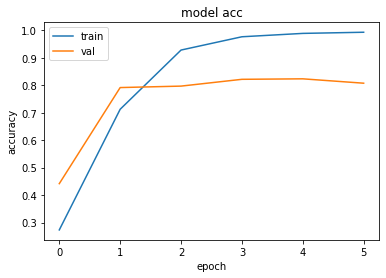

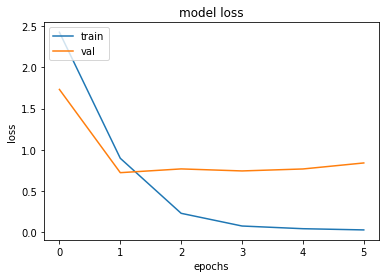

In [10]:
model_gru = Sequential([Embedding(input_dim=vocab_size+1, output_dim=embed_dim, weights= [embedding_matrix], input_length=sl, trainable = True ),
                        GRU(hidden_dim,dropout=0.2),
                        Dense(hidden_dim,activation='relu'),
                        Dense(output_dim,activation='softmax')])

history_gru = run_model(model_gru, train_tokenized_seq, train_labels, epochs, batch_size, vsplit)

print("Evaluating...")
evaluate(model_gru, test_tokenized_seq, test_labels, batch_size)
# plot curves
training_plots(history_gru, 'simple_gru.png', model_gru)

## 3) BiGRU

START TRAINING
Train on 10748 samples, validate on 566 samples
Epoch 1/10
10748/10748 [==============================] - 50s 5ms/step - loss: 2.6817 - categorical_accuracy: 0.1807 - val_loss: 2.1036 - val_categorical_accuracy: 0.3163
Epoch 2/10
10748/10748 [==============================] - 49s 5ms/step - loss: 1.3289 - categorical_accuracy: 0.5591 - val_loss: 0.9143 - val_categorical_accuracy: 0.7279

Epoch 00002: val_categorical_accuracy improved from -inf to 0.72792, saving model to 02_0.73.h5
Epoch 3/10
10748/10748 [==============================] - 49s 5ms/step - loss: 0.4534 - categorical_accuracy: 0.8584 - val_loss: 0.7164 - val_categorical_accuracy: 0.8110
Epoch 4/10
10748/10748 [==============================] - 49s 5ms/step - loss: 0.1938 - categorical_accuracy: 0.9387 - val_loss: 0.7809 - val_categorical_accuracy: 0.8269

Epoch 00004: val_categorical_accuracy improved from 0.72792 to 0.82686, saving model to 04_0.83.h5
Epoch 5/10
10748/10748 [==============================] 

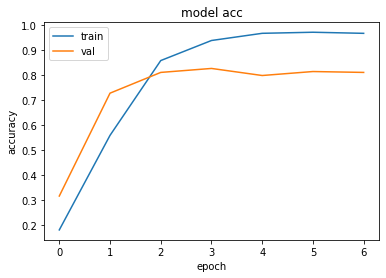

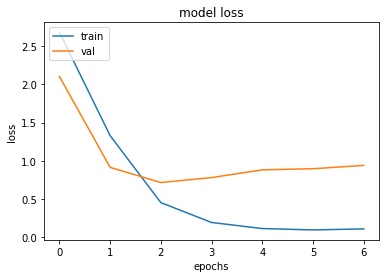

In [15]:
model_BiGRU = Sequential([Embedding(input_dim=vocab_size+1, output_dim=embed_dim, weights= [embedding_matrix], input_length=sl, trainable = True ),
                        Bidirectional(GRU(hidden_dim,dropout=0.2)),
                        Dense(hidden_dim,activation='relu'),
                        Dense(output_dim,activation='softmax')])

history_bigru = run_model(model_BiGRU, train_tokenized_seq, train_labels, epochs, batch_size, vsplit)

print("Evaluating...")
evaluate(model_BiGRU, test_tokenized_seq, test_labels, batch_size)
# plot curves
training_plots(history_bigru, 'BiGRU.png', model_BiGRU)